# 微调大模型:ChatGLM3-6B 进行二分类任务

## 导入数据

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
train_df = pd.read_csv('./csv_data/train.csv')
testB_df = pd.read_csv('./csv_data/testB.csv')

## 制作数据集

In [4]:
res = []

for i in range(len(train_df)):
    paper_item = train_df.loc[i]
    tmp = {
    "instruction": "Please judge whether it is a medical field paper according to the given paper title and abstract, output 1 or 0, the following is the paper title and abstract -->",
    "input": f"title:{paper_item[1]},abstract:{paper_item[3]}",
    "output": str(paper_item[5])
  }
    res.append(tmp)

In [ ]:
import json

with open('./data/paper_label.json', mode='w', encoding='utf-8') as f:
    json.dump(res, f, ensure_ascii=False, indent=4)

## 加载训练好的LoRA权重，进行预测

In [4]:
from peft import PeftModel
from transformers import AutoTokenizer, AutoModel, GenerationConfig, AutoModelForCausalLM

model_path = "../ZhipuAI/chatglm3-6b"
model = AutoModel.from_pretrained(model_path, trust_remote_code=True).half().cuda()
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
# 加载 label lora权重
model = PeftModel.from_pretrained(model, './output/label_xfg').half()
model = model.eval()
response, history = model.chat(tokenizer, "你好", history=[])
response

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Setting eos_token is not supported, use the default one.
Setting pad_token is not supported, use the default one.
Setting unk_token is not supported, use the default one.


'你好👋！我是人工智能助手 ChatGLM3-6B，很高兴见到你，欢迎问我任何问题。'

In [5]:
# 预测函数

def predict(text):
    response, history = model.chat(tokenizer, f"Please judge whether it is a medical field paper according to the given paper title and abstract, output 1 or 0, the following is the paper title, author and abstract -->{text}", history=[],
    temperature=0.01)
    return response

In [6]:
predict('title:Seizure Detection and Prediction by Parallel Memristive Convolutional Neural Networks,author:Li, Chenqi; Lammie, Corey; Dong, Xuening; Amirsoleimani, Amirali; Azghadi, Mostafa Rahimi; Genov, Roman,abstract:During the past two decades, epileptic seizure detection and prediction algorithms have evolved rapidly. However, despite significant performance improvements, their hardware implementation using conventional technologies, such as Complementary Metal-Oxide-Semiconductor (CMOS), in power and areaconstrained settings remains a challenging task; especially when many recording channels are used. In this paper, we propose a novel low-latency parallel Convolutional Neural Network (CNN) architecture that has between 2-2,800x fewer network parameters compared to State-Of-The-Art (SOTA) CNN architectures and achieves 5-fold cross validation accuracy of 99.84% for epileptic seizure detection, and 99.01% and 97.54% for epileptic seizure prediction, when evaluated using the University of Bonn Electroencephalogram (EEG), CHB-MIT and SWEC-ETHZ seizure datasets, respectively. We subsequently implement our network onto analog crossbar arrays comprising Resistive Random-Access Memory (RRAM) devices, and provide a comprehensive benchmark by simulating, laying out, and determining hardware requirements of theCNNcomponent of our system. We parallelize the execution of convolution layer kernels on separate analog crossbars to enable 2 orders of magnitude reduction in latency compared to SOTA hybrid Memristive-CMOS Deep Learning (DL) accelerators. Furthermore, we investigate the effects of non-idealities on our system and investigate Quantization Aware Training (QAT) to mitigate the performance degradation due to lowAnalog-to-Digital Converter (ADC)/Digital-to-Analog Converter (DAC) resolution. Finally, we propose a stuck weight offsetting methodology to mitigate performance degradation due to stuck RON/ROFF memristor weights, recovering up to 32% accuracy, without requiring retraining. The CNN component of our platform is estimated to consume approximately 2.791Wof power while occupying an area of 31.255 mm(2) in a 22 nm FDSOI CMOS process.')

'1'

In [7]:
x = train_df.drop('label',axis = 1)
y = train_df['label']

In [8]:
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y, train_size=0.7) #30%为测试集，则70%为训练集

In [9]:
# 预测测试集

from tqdm import tqdm

label = []

for i in tqdm(range(len(x))):
    test_item = x.loc[i]
    test_input = f"title:{test_item[1]},author:{test_item[2]},abstract:{test_item[3]}"
    label.append(int(predict(test_input)))


100%|██████████| 6000/6000 [12:04<00:00,  8.29it/s]


In [12]:
#验证代码正确性并输出结果
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print("Confusion Matrix:")
print(confusion_matrix(y, label))  # 输出混淆矩阵
print("Classification Report:")
print(classification_report(y, label))  # 输出分类报告
print("Accuracy:") #输出精度
print(accuracy_score(y, label))

Confusion Matrix:
[[3024   55]
 [  25 2896]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3079
           1       0.98      0.99      0.99      2921

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000

Accuracy:
0.9866666666666667


In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [19]:
fpr, tpr, _ = roc_curve(y, label)  # 计算ROC曲线
roc_auc = auc(fpr, tpr)  # 计算AUC值

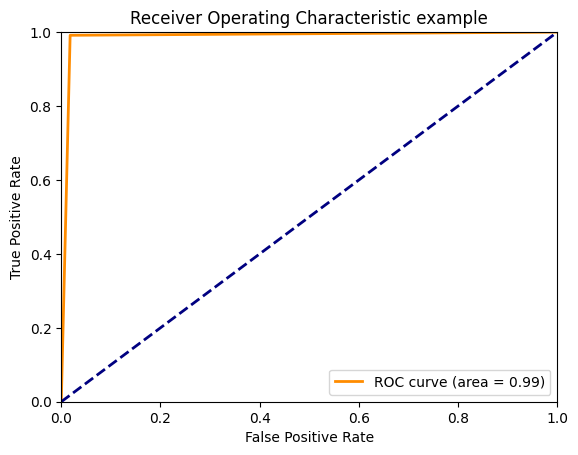

In [21]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  # 画出ROC曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # 画出随机分类器的ROC曲线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic example')
plt.legend(loc="lower right")
plt.show()